# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [78]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.model_selection import ShuffleSplit
from sklearn.impute import KNNImputer

In [3]:
import catboost as cb
from catboost import CatBoostRegressor

# Data loading

In [41]:
raw_data = pd.read_csv('data/olx_house_price_Q122.csv')

Features description: <br/>
offer_title: offer title <br/>
price: price in PLN <br/>
price_per_meter: price in PLN for square meter <br/>
offer_type: as value name <br/>
floor: floor number for -1 --> basement, 0 --> Ground Floor, 10 --> floor 10+, 11 --> attic <br/>
area: area in square meters
rooms: number of rooms for 4 --> rooms 4+ <br/>
offer_type_of_building: as value name <br/>
market: as value name <br/>
city_name: name of city where home is <br/>
voivodeship: name of voivodeship where home is <br/>
month: data download month <br/>
year: data download year <br/>
population: city population where home is <br/>
longitude``latitude: city coordinates <br/>

In [6]:
raw_data.shape

(62818, 16)

# Vars

In [43]:
target_column =['price']
subtarget_cut_column = ['offer_title']
number_columns = ['floor',  'area', 'rooms', 'population', 'longitude', 'latitude']
cat_columns = ['offer_type', 'offer_type_of_building', 'market', 'city_name', 'voivodeship']
date_columns = ['month']

# Preprocessing

In [65]:
data = raw_data.copy()

## Area, price, price_per_meter nans

In [60]:
data[data['area'].isna()].shape

(1487, 16)

In [46]:
data[data['price'].isna()].shape

(0, 16)

In [47]:
data[data['price_per_meter'].isna()].shape

(0, 16)

## Fill nan area

In [68]:
data['area'] = data['area'].fillna(data['price']/data['price_per_meter'])

In [69]:
data[data['area'].isna()]

,offer_title,price,price_per_meter,offer_type,floor,area,rooms,offer_type_of_building,market,city_name,voivodeship,month,year,population,longitude,latitude


## Checking correct of price per meter & price

In [13]:
data['price_per_meter_calculated'] = data['price']/data['area']
data['price_per_meter_calculated'] = np.floor(data['price_per_meter_calculated'])
data['price_per_meter'] = np.floor(data['price_per_meter'])

In [14]:
data[((data['price_per_meter_calculated']-data['price_per_meter'])>1) | ((data['price_per_meter_calculated']-data['price_per_meter'])<-2)][['price_per_meter_calculated', 'price_per_meter']]

,price_per_meter_calculated,price_per_meter


Everything look allright

## Anomaly areas

Low price per square meter

In [15]:
data[data['area']>1000].shape

(72, 17)

>300 < 1000 looks good

In [16]:
data[(data['area']>300) & (data['area']<=1000)].shape

(60, 17)

In [76]:
data = data[data['area']<1000]

## Year in the data set is uninformable, cause it is a constant value <br/>
## price_per_meter is the same as out target value price

## offer_title droping

In [70]:
data['year'].unique()

array([2022])

In [71]:
data = data.drop(columns=['year', 'price_per_meter', 'offer_title'])

## nans

In [72]:
data['offer_type_of_building'] = data['offer_type_of_building'].fillna('Unknown')

## floors nans

In [73]:
data['floor'].unique()

array([ 1.,  2.,  3.,  5.,  4., nan,  0.,  9.,  7.,  6., 10.,  8., 11.,
       -1.])

dummy

In [81]:
def undummify(df, prefix_sep="_"):
    cols2collapse = {
        item.rsplit(prefix_sep, 1)[0]: (prefix_sep in item) for item in df.columns
    }
    series_list = []
    for col, needs_to_collapse in cols2collapse.items():
        if needs_to_collapse:
            undummified = (
                df.filter(like=col)
                .idxmax(axis=1)
                .apply(lambda x: x.rsplit(prefix_sep, 1)[1])
                .rename(col)
            )
            series_list.append(undummified)
        else:
            series_list.append(df[col])
    undummified_df = pd.concat(series_list, axis=1)
    return undummified_df

In [86]:
data_dummy = pd.get_dummies(data)

In [87]:
dummy_columns = data_dummy.columns

In [88]:
imputer = KNNImputer(n_neighbors=5)
data_dummy = imputer.fit_transform(data_dummy)

In [89]:
data_dummy = pd.DataFrame(data_dummy, columns=dummy_columns)

In [90]:
data_dummy = undummify(data_dummy)

In [93]:
data = data_dummy

# Correlation

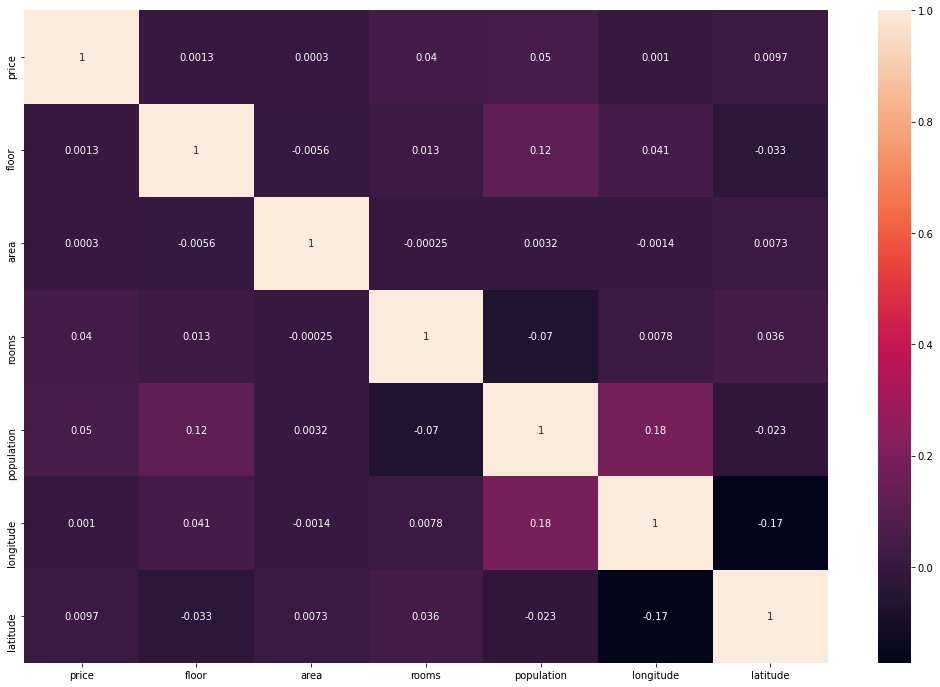

In [21]:
plt.figure(figsize=(18, 12))
sns.heatmap(data.corr(), annot=True)
plt.show()

# Lineplot numeric/target

In [22]:
# fig, axes = plt.subplots(2, 3, figsize=(25,12))
# axes = axes.flatten()
# for ax, num_c in zip(axes, number_columns):
#     sns.lineplot(data=data, x=num_c, y='price', ax=ax)
# plt.show()

# Categoril features

## Dependence between long/lang and city

In [25]:
ll_c = data['city_name'].value_counts()[data['city_name'].value_counts()> 500]
# ll_c

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

/home/dzmitry/.local/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 129 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/dzmitry/.local/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 129 missing from current font.
  font.set_text(s, 0, flags=flags)


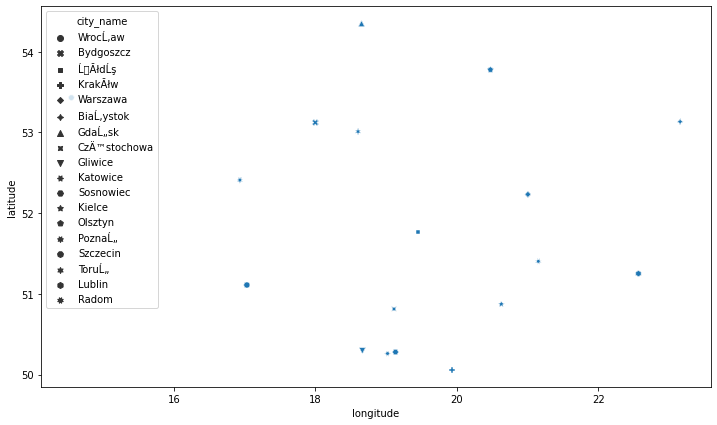

In [26]:
plt.figure(figsize=(12, 7))
sns.scatterplot(data=data[data['city_name'].isin(ll_c.index)], x='longitude', y='latitude', style='city_name')

100% dependece between Long, lat and city

In [27]:
data.head(2)

,price,offer_type,floor,area,rooms,offer_type_of_building,market,city_name,voivodeship,month,population,longitude,latitude
0,240000.0,Private,1.0,27.0,1,Housing Block,primary,BolesĹ‚awiec,Lower Silesia,January,39603,15.565105,51.263033
1,250000.0,Private,1.0,35.0,1,Housing Block,primary,Jelcz-Laskowice,Lower Silesia,January,15828,17.349964,51.039831


In [28]:
ll_data = data[['offer_type', 'floor', 'area', 'rooms',
       'offer_type_of_building', 'market', 'voivodeship', 'month',
       'population', 'longitude', 'latitude']]
ll_target = data['price']
c_data = data[['offer_type', 'floor', 'area', 'rooms',
       'offer_type_of_building', 'market', 'voivodeship', 'month',
       'population', 'city_name']]
c_target = data['price']
f_data = data[['offer_type', 'floor', 'area', 'rooms',
       'offer_type_of_building', 'market', 'voivodeship', 'month',
       'population', 'longitude', 'latitude', 'city_name']]
f_target = data['price']
ll_without_voiv_data = data[['offer_type', 'floor', 'area', 'rooms',
       'offer_type_of_building', 'market', 'month',
       'population', 'longitude', 'latitude']]
ll_without_voiv_target = data['price']

In [29]:
ll_features_indecies = [0, 4, 5, 6, 7]
c_features_indecies = [0, 4, 5, 6, 7, 9]
f_features_indecies = [0, 4, 5, 6, 7, 11]
ll_without_voiv_indecies = [0, 4, 5, 6]

In [30]:
params_cv_city = {"iterations": 30,
          "depth": 10,
          "loss_function": "RMSE",
          "random_state": 5,
          "learning_rate": 1}

In [31]:
city_scores = []

In [32]:
def print_cv_summary(cv_data):
    cv_data.head(10)
    mean_value = cv_data['test-RMSE-mean'].mean()
    best_value = cv_data['test-RMSE-mean'].min()
    print(f'Mean: {mean_value}, best: {best_value}')

In [33]:
for data_f, target, f_indecies in zip([ll_data, c_data, f_data, ll_without_voiv_data], [ll_target, c_target, f_target, ll_without_voiv_target], [ll_features_indecies, c_features_indecies, f_features_indecies, ll_without_voiv_indecies]):
    # X_train, X_test, y_train, y_test = train_test_split(data_f, target, test_size = 0.2, random_state=5)
    cv_dataset = cb.Pool(data_f, target, cat_features=f_indecies)

    scores = cb.cv(cv_dataset,
            params_cv_city,
            fold_count=10, 
            plot=False,
            shuffle=True,
            stratified=False,
            verbose=False)
    city_scores.append(scores)

Training on fold [0/10]

bestTest = 168447.7806
bestIteration = 2

Training on fold [1/10]

bestTest = 124240.705
bestIteration = 10

Training on fold [2/10]

bestTest = 144053.5796
bestIteration = 29

Training on fold [3/10]

bestTest = 141694.7142
bestIteration = 29

Training on fold [4/10]

bestTest = 148537.5913
bestIteration = 29

Training on fold [5/10]

bestTest = 124954.071
bestIteration = 29

Training on fold [6/10]

bestTest = 159294.9328
bestIteration = 0

Training on fold [7/10]

bestTest = 1594518.8
bestIteration = 3

Training on fold [8/10]

bestTest = 6356611.859
bestIteration = 15

Training on fold [9/10]

bestTest = 153662.8504
bestIteration = 29

Training on fold [0/10]

bestTest = 167357.9069
bestIteration = 3

Training on fold [1/10]

bestTest = 136617.9206
bestIteration = 3

Training on fold [2/10]

bestTest = 151845.3182
bestIteration = 3

Training on fold [3/10]

bestTest = 165432.7795
bestIteration = 3

Training on fold [4/10]

bestTest = 164606.4954
bestIterati

In [34]:
for cs in city_scores:
    print_cv_summary(cs)

Mean: 1033288.7765918208, best: 953635.0920482666
Mean: 1472208.2352355677, best: 1063865.0218347604
Mean: 1391875.3015256387, best: 1000255.9054869211
Mean: 1089738.6993621055, best: 935008.2903553859


Long and lad give the best results - remove city from dataset

Voivodeship less error range

In [94]:
data = data.drop(columns=['city_name'])

In [37]:
data.to_csv('data/prepared_data.csv', index=False)

# First model

In [38]:
print 'a'

SyntaxError: Missing parentheses in call to 'print'. Did you mean print('a')? (2996665661.py, line 1)

In [ ]:
cat_features_indecies = [0, 4, 5, 6, 7, 8]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=['price']), data['price'], test_size = 0.2, random_state=5)

In [ ]:
train_dataset = cb.Pool(X_train, y_train, cat_features=cat_features_indecies) 
test_dataset = cb.Pool(X_test, y_test, cat_features=cat_features_indecies)

In [ ]:
model = CatBoostRegressor(iterations=33,
                          learning_rate=1,
                          depth=10,
                          loss_function='RMSE')

In [ ]:
model.fit(train_dataset)

0:	learn: 2253986.9813076	total: 4.86ms	remaining: 156ms
1:	learn: 1694114.0105243	total: 24.2ms	remaining: 375ms
2:	learn: 1275027.0722555	total: 44.8ms	remaining: 448ms
3:	learn: 962891.0320805	total: 74.7ms	remaining: 542ms
4:	learn: 957118.1520790	total: 97.3ms	remaining: 545ms
5:	learn: 953557.4759838	total: 122ms	remaining: 548ms
6:	learn: 953086.7988851	total: 138ms	remaining: 514ms
7:	learn: 951771.7536926	total: 160ms	remaining: 501ms
8:	learn: 949977.5637577	total: 185ms	remaining: 493ms
9:	learn: 949831.1644769	total: 209ms	remaining: 482ms
10:	learn: 719397.8664436	total: 229ms	remaining: 458ms
11:	learn: 548082.4040857	total: 256ms	remaining: 448ms
12:	learn: 547684.3583962	total: 289ms	remaining: 444ms
13:	learn: 541736.7928434	total: 321ms	remaining: 435ms
14:	learn: 540693.8567408	total: 351ms	remaining: 422ms
15:	learn: 457023.5004890	total: 375ms	remaining: 399ms
16:	learn: 356052.5715632	total: 401ms	remaining: 378ms
17:	learn: 352069.0852595	total: 431ms	remaining: 

In [ ]:
preds = model.predict(test_dataset)

In [ ]:
r2_score(y_test, preds)

0.5166794507948574

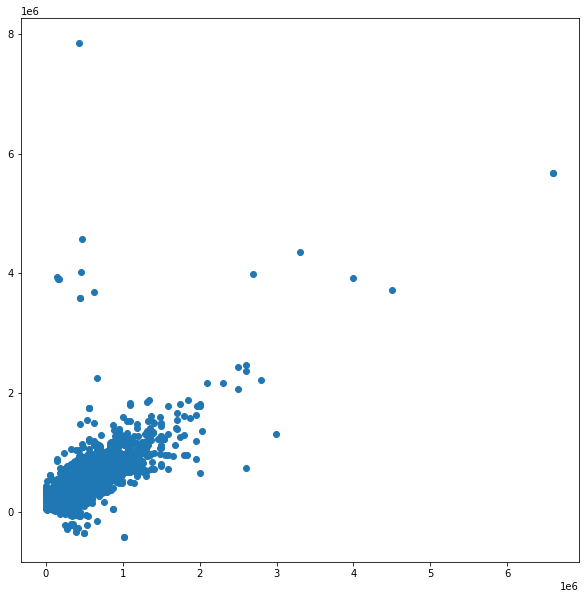

In [ ]:
plt.figure(figsize=(10, 10))
plt.scatter(y_test, preds)
# plt.plot(y_test)
plt.show()